# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# TabNet library
#
from pytorch_tabnet.tab_model import TabNetRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [4]:
Lag        =   12
Horizon    =    4

# Data handling

## Import data


In [5]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.29 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [6]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['CO'] )
df.head(3)

,CO
Date,
2022-02-19 00:00:00,248.947368
2022-02-19 00:05:00,232.473684
2022-02-19 00:10:00,226.947368


In [7]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [8]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

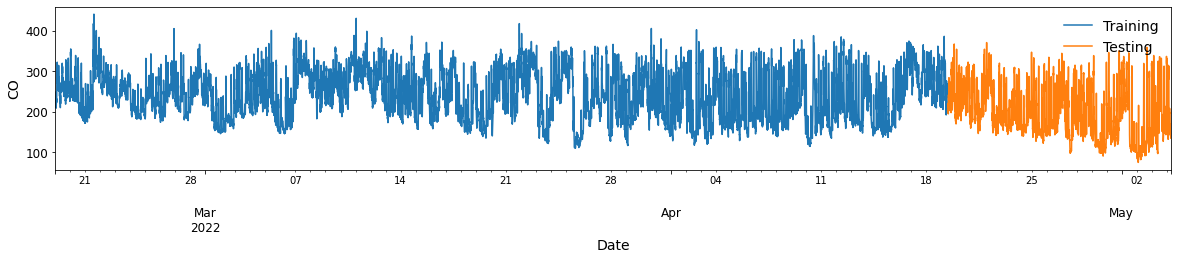

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [10]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [11]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(-df.min().min(), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [12]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [13]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ][i:(i+Lag-1)]).to_list()
#         # Time
#         Instance.append( df.index[i+Lag-1].hour + df.index[i+Lag-1].minute / 60) 
        # Current value
        Instance.append( df[ targetSeries ].to_numpy()[i+Lag-1] )

           
        

        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY) )

In [14]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 4277/4277 [00:00<00:00, 5404.73it/s]

Training instances:     4276
Testing instances:      4277


In [15]:
trainX.shape, trainY.shape

((4276, 12), (4276, 4))

# Forecasting model: TabNet

## Setup model

In [16]:
model = TabNetRegressor(verbose = 1, 
                        seed    = 42)

Device used : cpu


## Training process

In [17]:
import torch.nn as nn

# Start clock
#
start = time.time()

# Train model
#
model.fit(X_train = trainX, 
          y_train = trainY,
          loss_fn = nn.MSELoss(), # nn.L1Loss(), nn.MSELoss()
          #
          eval_set    = [(testX, testY)],
          batch_size  = 32,
          num_workers = 0,
          patience    = 200, 
          max_epochs  = 2000,
          eval_metric = ['rmse'])

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

epoch 0  | loss: 0.24134 | val_0_rmse: 0.59067 |  0:00:02s
epoch 1  | loss: 0.18347 | val_0_rmse: 0.58393 |  0:00:05s
epoch 2  | loss: 0.18088 | val_0_rmse: 0.58619 |  0:00:08s
epoch 3  | loss: 0.17816 | val_0_rmse: 0.58287 |  0:00:11s
epoch 4  | loss: 0.17856 | val_0_rmse: 0.5812  |  0:00:14s
epoch 5  | loss: 0.17984 | val_0_rmse: 0.57888 |  0:00:17s
epoch 6  | loss: 0.17776 | val_0_rmse: 0.57423 |  0:00:20s
epoch 7  | loss: 0.17697 | val_0_rmse: 0.58058 |  0:00:22s
epoch 8  | loss: 0.17791 | val_0_rmse: 0.57756 |  0:00:25s
epoch 9  | loss: 0.17665 | val_0_rmse: 0.57252 |  0:00:28s
epoch 10 | loss: 0.17589 | val_0_rmse: 0.57846 |  0:00:30s
epoch 11 | loss: 0.17591 | val_0_rmse: 0.57972 |  0:00:33s
epoch 12 | loss: 0.17645 | val_0_rmse: 0.57972 |  0:00:36s
epoch 13 | loss: 0.17774 | val_0_rmse: 0.58001 |  0:00:39s
epoch 14 | loss: 0.1774  | val_0_rmse: 0.57814 |  0:00:41s
epoch 15 | loss: 0.17721 | val_0_rmse: 0.58347 |  0:00:44s
epoch 16 | loss: 0.17518 | val_0_rmse: 0.56639 |  0:00:4

epoch 139| loss: 0.17163 | val_0_rmse: 0.57274 |  0:06:48s
epoch 140| loss: 0.17019 | val_0_rmse: 0.58953 |  0:06:53s
epoch 141| loss: 0.17019 | val_0_rmse: 0.5766  |  0:06:59s
epoch 142| loss: 0.16935 | val_0_rmse: 0.56686 |  0:07:05s
epoch 143| loss: 0.16923 | val_0_rmse: 0.56888 |  0:07:11s
epoch 144| loss: 0.17016 | val_0_rmse: 0.56891 |  0:07:17s
epoch 145| loss: 0.16813 | val_0_rmse: 0.57104 |  0:07:24s
epoch 146| loss: 0.16927 | val_0_rmse: 0.57018 |  0:07:30s
epoch 147| loss: 0.16959 | val_0_rmse: 0.5692  |  0:07:39s
epoch 148| loss: 0.16873 | val_0_rmse: 0.56994 |  0:07:48s
epoch 149| loss: 0.16906 | val_0_rmse: 0.5675  |  0:07:55s
epoch 150| loss: 0.16891 | val_0_rmse: 0.57191 |  0:08:03s
epoch 151| loss: 0.17026 | val_0_rmse: 0.56814 |  0:08:08s
epoch 152| loss: 0.16797 | val_0_rmse: 0.57076 |  0:08:13s
epoch 153| loss: 0.16809 | val_0_rmse: 0.56744 |  0:08:18s
epoch 154| loss: 0.16921 | val_0_rmse: 0.56677 |  0:08:21s
epoch 155| loss: 0.16944 | val_0_rmse: 0.56844 |  0:08:2

epoch 278| loss: 0.17136 | val_0_rmse: 0.56928 |  0:15:49s
epoch 279| loss: 0.1708  | val_0_rmse: 0.5707  |  0:15:52s
epoch 280| loss: 0.17066 | val_0_rmse: 0.57263 |  0:15:55s
epoch 281| loss: 0.16914 | val_0_rmse: 0.56756 |  0:15:58s
epoch 282| loss: 0.17032 | val_0_rmse: 0.5702  |  0:16:00s
epoch 283| loss: 0.1697  | val_0_rmse: 0.57114 |  0:16:04s
epoch 284| loss: 0.17069 | val_0_rmse: 0.56616 |  0:16:07s
epoch 285| loss: 0.17082 | val_0_rmse: 0.56911 |  0:16:10s
epoch 286| loss: 0.1696  | val_0_rmse: 0.56586 |  0:16:12s
epoch 287| loss: 0.17038 | val_0_rmse: 0.57152 |  0:16:15s
epoch 288| loss: 0.16903 | val_0_rmse: 0.57021 |  0:16:18s
epoch 289| loss: 0.17005 | val_0_rmse: 0.56883 |  0:16:20s
epoch 290| loss: 0.17038 | val_0_rmse: 0.56401 |  0:16:23s
epoch 291| loss: 0.17034 | val_0_rmse: 0.57065 |  0:16:26s
epoch 292| loss: 0.16947 | val_0_rmse: 0.56949 |  0:16:28s
epoch 293| loss: 0.17015 | val_0_rmse: 0.57002 |  0:16:31s
epoch 294| loss: 0.17043 | val_0_rmse: 0.56722 |  0:16:3

## Evaluation

### Get predictions

In [18]:
# Get predictions
#
pred = model.predict( testX )


### Inverse "Lag-d Diff" transformation

In [19]:
for i in range( Horizon ):
    testY[:, i] = testX[:, -1] - testY[:, i]
    pred[:, i]  = testX[:, -1] - pred[:, i]

### Apply inverse scaling/transformation

In [20]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [21]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i]   



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE 10.15 SMAPE:  4.91 R2: 0.93
Horizon:  2 MAE 17.75 SMAPE:  8.66 R2: 0.81
Horizon:  3 MAE 22.93 SMAPE: 11.30 R2: 0.70
Horizon:  4 MAE 27.24 SMAPE: 13.53 R2: 0.60


In [22]:
# CO - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE 10.15 SMAPE:  4.91 R2: 0.93
# Horizon:  2 MAE 17.75 SMAPE:  8.66 R2: 0.81
# Horizon:  3 MAE 22.93 SMAPE: 11.30 R2: 0.70
# Horizon:  4 MAE 27.24 SMAPE: 13.53 R2: 0.60

## Visualization

[INFO] Feature:  CO
------------------------------------------------


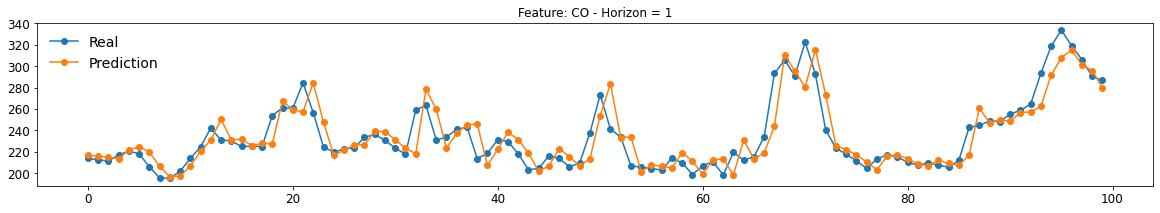

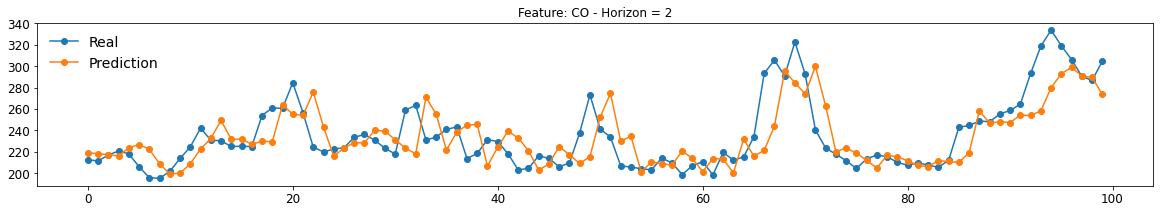

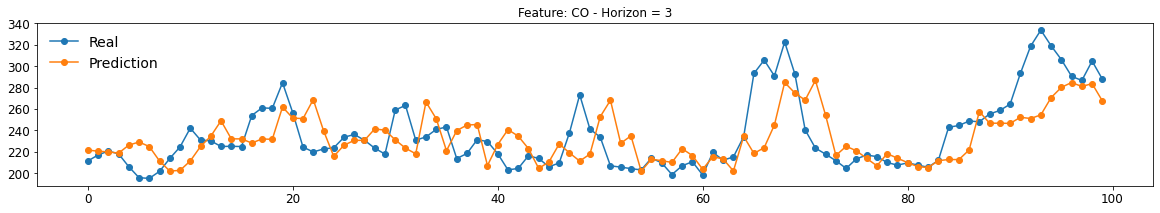

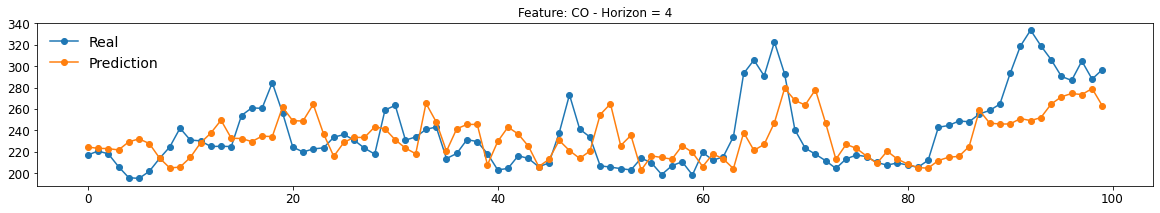

In [23]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i] 
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

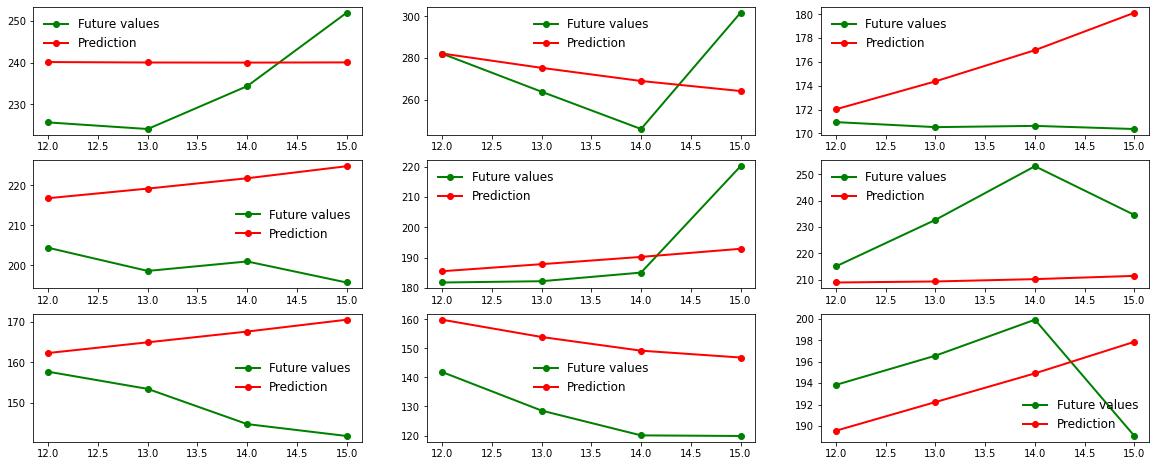

In [24]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [25]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries]  = testY.flatten()
Outputs['TabNet_diff'] = pred.flatten()
#
#
Outputs.to_csv('Predictions/TabNet_diff.csv')